<a href="https://colab.research.google.com/github/santhoshmohan8/timeseriesforecast/blob/main/SARIMAX_Forecast_and_Anamoly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**`SARIMAX time series forecast and anamoly detection - Catfish sales`**

Import packages and custom functions

In [1]:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# import csv data - catfish sales
def custom_date(date):
  return pd.datetime.strptime(date,"%Y-%m-%d")

def plot_timeseries(raw_data,forecast_data=None,forecast_data2=None):
  plt.figure(figsize=(12,5))
  forecast_data = raw_data if forecast_data is None else forecast_data
  forecast_data2 = raw_data if forecast_data2 is None else forecast_data2
  plt.plot(raw_data)
  plt.plot(forecast_data)
  plt.plot(forecast_data2)
  plt.legend()
  plt.title("Catfish sales actual data")
  plt.xlabel("Date")
  plt.ylabel("Sales")
  startdate, enddate = raw_data.index.min(), raw_data.index.max()
  for yr in range(startdate.year,enddate.year+1):
    plt.axvline(pd.to_datetime(str(yr)+'-03-01'), color='b', alpha=0.1, linestyle="--")

Import csv file and limiting problem dataset for forecast

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


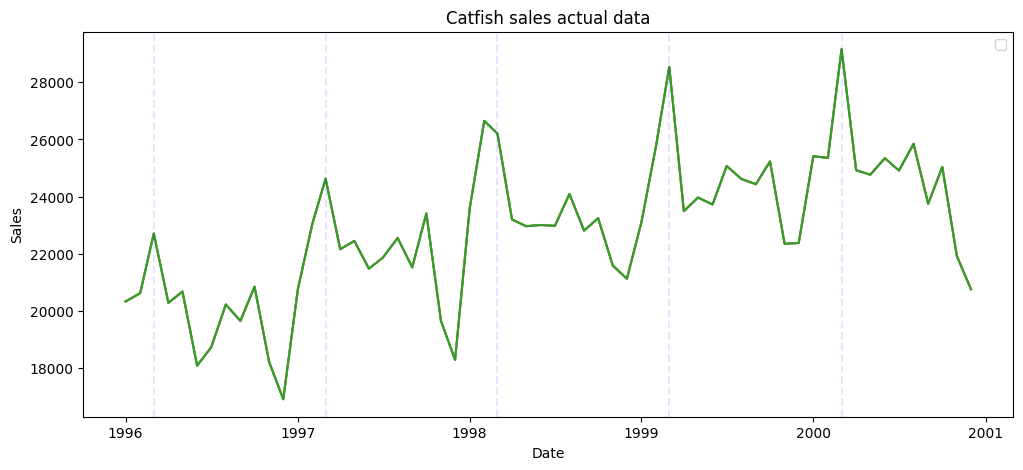

In [3]:
catfish = pd.read_csv('catfish.csv', index_col=0, parse_dates=[0], date_parser = custom_date, squeeze = True)
catfish.head()

# check freq and resampling to monthly freq
catfish = catfish.asfreq(pd.infer_freq(catfish.index))

catfish.index.min()
catfish.index.max()

#limiting problem dataset from 1996 till 2000
startdate = datetime(1996,1,1)
enddate = datetime(2000,12,1)
catfish = catfish[startdate:enddate]
catfish.shape
plot_timeseries(catfish)

Trend check - First difference or higher

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


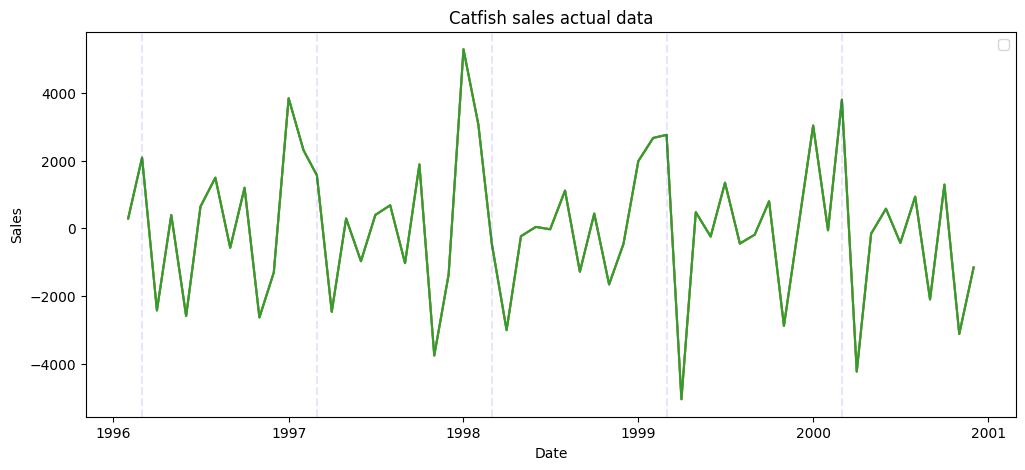

In [4]:
catfish_diff = catfish.diff()[1:]
plot_timeseries(catfish_diff)

# first difference satisfies stationary function

Forecast using SARIMAX model - No anamoly in dataset

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84340D+00    |proj g|=  1.03163D+00

At iterate    5    f=  8.60763D+00    |proj g|=  2.65156D-01

At iterate   10    f=  8.56675D+00    |proj g|=  1.49117D-02

At iterate   15    f=  8.56258D+00    |proj g|=  3.61618D-02

At iterate   20    f=  8.55568D+00    |proj g|=  1.75661D-02

At iterate   25    f=  8.55511D+00    |proj g|=  2.67268D-04

At iterate   30    f=  8.55506D+00    |proj g|=  4.06771D-03

At iterate   35    f=  8.54948D+00    |proj g|=  1.24140D-01

At iterate   40    f=  8.44023D+00    |proj g|=  3.04028D-01


 This problem is unconstrained.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



At iterate   45    f=  8.42331D+00    |proj g|=  3.96706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     54      1     0     0   2.465D-06   8.423D+00
  F =   8.4232315671637945     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RMSE: 1410.3175
MAPE: 0.0468


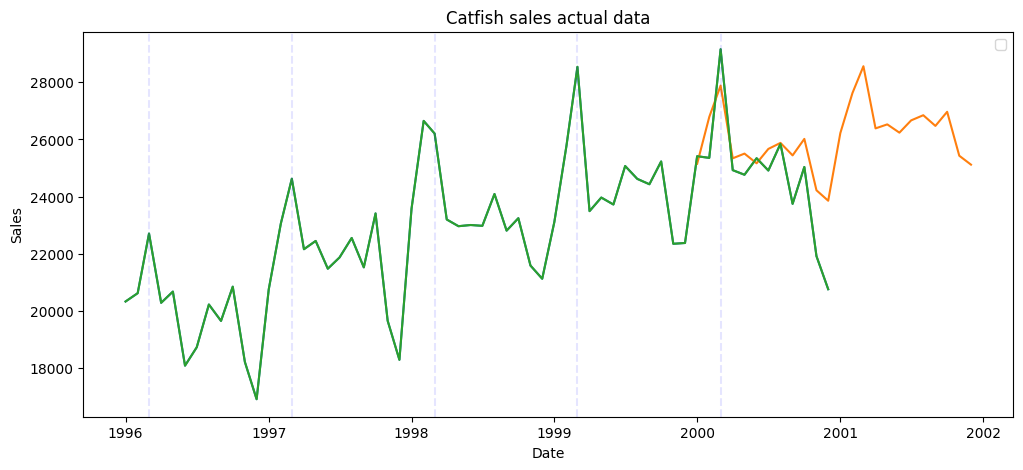

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# forecast mmodel 1 - static predictions
def SARIMAX_1(train,test):
  model = SARIMAX(train, order = (1,1,1), seasonal_order=(1,0,1,12)).fit()
  pred_test = model.get_forecast(steps=12).predicted_mean
  return pred_test

# forecast mmodel 2 - rolling predictions
def SARIMAX_2(train,test):
  rolling_prediction=pd.Series()
  for n in range(test.shape[0]):
    train_new = pd.concat([train,test[:n]],axis=0)
    model=SARIMAX(train_new, order = (1,1,1), seasonal_order=(1,0,1,12)).fit()
    rolling_prediction = rolling_prediction.append(model.forecast())
  return rolling_prediction

# model results - RMSE & MAPE
def model_results(y,y_pred):
  print("RMSE:",round(np.sqrt(np.mean((y - y_pred)**2)),4))
  print("MAPE:",round(np.mean(abs(y - y_pred)/y),4))

# train test split
train_enddate = datetime(1999,12,1)
train = catfish[:train_enddate]
test = catfish[train_enddate + timedelta(days=1):]

pred_data = SARIMAX_1(train,test)
# pred_roll = SARIMAX_2(train,test)
model_results(test,pred_data)
# model_results(test,pred_roll)

# plot_timeseries(catfish,pred_data,pred_roll)
plot_timeseries(catfish,pred_data)

In [11]:
pred_test

2000-01-01    25145.566356
2000-02-01    26788.655465
2000-03-01    27886.628035
2000-04-01    25339.116477
2000-05-01    25503.606485
2000-06-01    25164.286570
2000-07-01    25667.772376
2000-08-01    25879.010267
2000-09-01    25441.279859
2000-10-01    26018.960691
2000-11-01    24218.492780
2000-12-01    23852.593156
Freq: MS, Name: predicted_mean, dtype: float64

In [14]:
# model = SARIMAX(train, order = (1,1,1), seasonal_order=(1,0,1,12)).fit()
pred_test = model.get_forecast(start='2000-03-01', end='2000-10-01').predicted_mean
pred_test
# import pickle
# pickle.dump(model,open('model.pkl','wb'))

TypeError: get_prediction() got multiple values for keyword argument 'start'

Add anamoly -> Find Anamoly -> Normalize anamoly -> Plot

In [5]:
from sklearn.ensemble import IsolationForest

# Find anamoly
def find_anamoly(dataset,train,test):
  model_IF = IsolationForest(contamination=0.01).fit(train.values.reshape(-1,1))
  train_ana_scores = model_IF.decision_function(train.values.reshape(-1,1))
  test_ana_scores = model_IF.decision_function(test.values.reshape(-1,1))
  pred_anam_train = model_IF.predict(train.values.reshape(-1,1))
  pred_anam_test = model_IF.predict(test.values.reshape(-1,1))
  df_cf = pd.DataFrame(pd.concat([dataset,
                                  pd.Series(np.concatenate((pred_anam_train,pred_anam_test), axis=0), index=dataset.index),
                                  pd.Series(np.concatenate((train_ana_scores,test_ana_scores), axis=0), index=dataset.index)], axis=1))
  df_cf.rename(columns={'Total':'Sales',0:'Flag',1:'Ana_score'}, inplace=True)
  return df_cf

# normalize anamoly
def normalize_anamoly(df_cf):
  norm_df = df_cf.copy()
  anamoly_dates = norm_df[norm_df['Flag'] == -1].index
  for date in anamoly_dates:
    norm_df.loc[date,'Sales'] = norm_df[(norm_df.index.month == date.month) & (norm_df.index != date)].Sales.mean()
  return norm_df


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

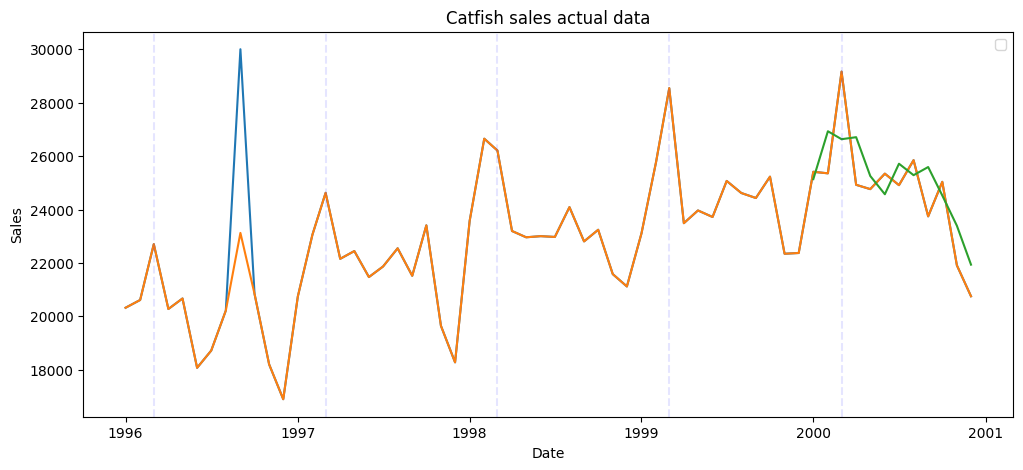

In [7]:
# Add, find, normalize, plot anamoly
catfish[datetime(1996,9,1)] = 30000
df_cf = find_anamoly(catfish,train,test)
norm_df = normalize_anamoly(df_cf)

# forecast timeseries
norm_forecast = norm_df['Sales']
train_enddate = datetime(1999,12,1)
train = norm_forecast[:train_enddate]
test = norm_forecast[train_enddate + timedelta(days=1):]

rolling_prediction = SARIMAX_2(train,test)
plot_timeseries(df_cf['Sales'],norm_df['Sales'],rolling_prediction)